In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions/text.csv


In [4]:
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AdamW
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

In [5]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
df = pd.read_csv('/kaggle/input/emotions/text.csv')

In [7]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [8]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [10]:
df.duplicated().sum()

686

In [11]:
df = df.drop_duplicates()

In [12]:
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [13]:
# Check the distribution of labels
label_counts = df['label'].value_counts()
label_counts

label
1    140779
0    120989
3     57235
4     47664
2     34497
5     14959
Name: count, dtype: int64

In [14]:
# Perform stratified sampling to create a balanced dataset
#balanced_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(10000))

# Split the balanced dataset into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=50)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=50)

# Check the distribution of labels in the balanced dataset
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())

label
1    112623
0     96791
3     45788
4     38131
2     27598
5     11967
Name: count, dtype: int64
label
1    14078
0    12099
3     5723
4     4766
2     3450
5     1496
Name: count, dtype: int64
label
1    14078
0    12099
3     5724
4     4767
2     3449
5     1496
Name: count, dtype: int64


In [15]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
# tokenize text data and encode labels
def preprocess_text(text):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64, 
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )

In [17]:
# apply preprocessing
train_df['input_ids'] = train_df['text'].apply(lambda x: preprocess_text(x)['input_ids'])
train_df['attention_mask'] = train_df['text'].apply(lambda x: preprocess_text(x)['attention_mask'])

val_df['input_ids'] = val_df['text'].apply(lambda x: preprocess_text(x)['input_ids'])
val_df['attention_mask'] = val_df['text'].apply(lambda x: preprocess_text(x)['attention_mask'])

test_df['input_ids'] = test_df['text'].apply(lambda x: preprocess_text(x)['input_ids'])
test_df['attention_mask'] = test_df['text'].apply(lambda x: preprocess_text(x)['attention_mask'])

# convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['label'].values)
val_labels = torch.tensor(val_df['label'].values)
test_labels = torch.tensor(test_df['label'].values)

In [18]:
# custom PyTorch Dataset
class EmotionsDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

train_dataset = EmotionsDataset(train_df['input_ids'].tolist(), train_df['attention_mask'].tolist(), train_labels)
val_dataset = EmotionsDataset(val_df['input_ids'].tolist(), val_df['attention_mask'].tolist(), val_labels)
test_dataset = EmotionsDataset(test_df['input_ids'].tolist(), test_df['attention_mask'].tolist(), test_labels)

# create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
from transformers import get_linear_schedule_with_warmup

In [20]:

num_classes = len(train_df['label'].unique())

epochs = 5

total_steps = len(train_loader) * epochs

# pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

dropout_rate = 0.5
model.dropout1 = nn.Dropout(dropout_rate)

# Batch normalization
batch_norm = nn.BatchNorm1d(768)

model.dropout2 = nn.Dropout(dropout_rate)

# optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# loss function
loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [21]:

num_epochs = 5 

for epoch in range(num_epochs):
    model.train() 
    total_loss = 0.0 
    
    for batch in train_loader:
        
        inputs = batch['input_ids'].squeeze(1).to(device)
        attention_masks = batch['attention_mask'].squeeze(1).to(device)
        labels = batch['labels'].to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs, attention_mask=attention_masks, labels=labels)

        # compute loss
        loss = outputs.loss

        # backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        
    # calc avg training loss
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}: Avg. Training Loss: {avg_train_loss:.4f}")

    # validation loop
    model.eval() 
    val_loss = 0.0
    num_val_batches = len(val_loader)
    val_preds = [] 
    val_true_labels = [] 

    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs = val_batch['input_ids'].squeeze(1).to(device)
            val_attention_masks = val_batch['attention_mask'].squeeze(1).to(device)
            val_true = val_batch['labels'].to(device)

            val_outputs = model(val_inputs, attention_mask=val_attention_masks, labels=val_true) 
            val_loss += val_outputs.loss.item()

            # store predictions
            val_preds.extend(torch.argmax(val_outputs.logits, axis=1).cpu().numpy().tolist())
            val_true_labels.extend(val_true.cpu().numpy().tolist())

    avg_val_loss = val_loss / num_val_batches
    print(f"Epoch {epoch+1}/{num_epochs}: Avg. Validation Loss: {avg_val_loss:.4f}")

    # eval metrics
    val_accuracy = accuracy_score(val_true_labels, val_preds)
    val_f1 = f1_score(val_true_labels, val_preds, average='weighted')
    print(f"Epoch {epoch+1}/{num_epochs}: Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")

Epoch 1/5: Avg. Training Loss: 0.1285
Epoch 1/5: Avg. Validation Loss: 0.0881
Epoch 1/5: Validation Accuracy: 0.9416, Validation F1 Score: 0.9426
Epoch 2/5: Avg. Training Loss: 0.0873
Epoch 2/5: Avg. Validation Loss: 0.0857
Epoch 2/5: Validation Accuracy: 0.9435, Validation F1 Score: 0.9415
Epoch 3/5: Avg. Training Loss: 0.0822
Epoch 3/5: Avg. Validation Loss: 0.0850
Epoch 3/5: Validation Accuracy: 0.9435, Validation F1 Score: 0.9442
Epoch 4/5: Avg. Training Loss: 0.0789
Epoch 4/5: Avg. Validation Loss: 0.0871
Epoch 4/5: Validation Accuracy: 0.9425, Validation F1 Score: 0.9427
Epoch 5/5: Avg. Training Loss: 0.0771
Epoch 5/5: Avg. Validation Loss: 0.0900
Epoch 5/5: Validation Accuracy: 0.9428, Validation F1 Score: 0.9436


In [22]:
model.eval()  
test_preds = [] 
test_labels = []  

with torch.no_grad():
    for test_batch in test_loader:
        test_inputs = test_batch['input_ids'].squeeze(1).to(device)
        test_attention_masks = test_batch['attention_mask'].squeeze(1).to(device)
        test_true_labels = test_batch['labels'].to(device)

        # forward pass test
        test_outputs = model(test_inputs, attention_mask=test_attention_masks)
        
        # store predictions
        test_preds.extend(torch.argmax(test_outputs.logits, axis=1).cpu().numpy().tolist())
        test_labels.extend(test_true_labels.cpu().numpy().tolist())

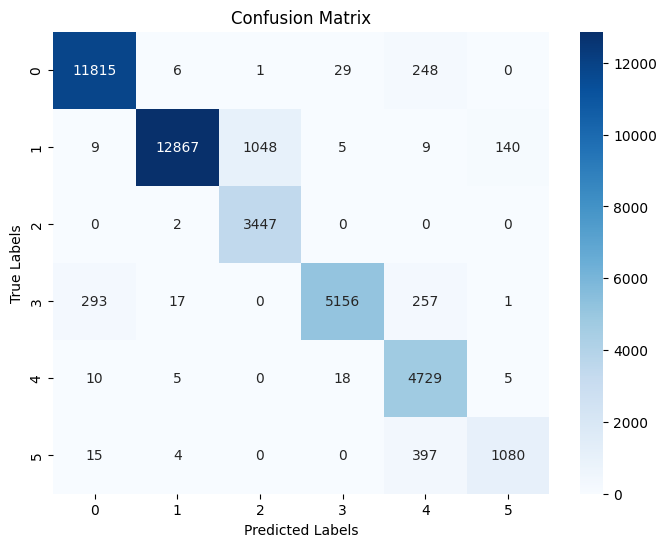

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print("\nConfusion matrix - BERT:")
conf_matrix

In [25]:
# Generate classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

Weighted F1 Score: 0.9404
